# Hybrid attack

### Load results 

In [21]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from itertools import product

# parameters 
dataset_names = ['cora', 'polblogs']
graph1_props = [0.0]
common_props = [0]
sns.set(font_scale=1.2)
sns.set_theme(style="whitegrid")

graph_statistics = {
    "acm" : {
        "nodes": 3025,
        "edges": 13128,
    },
    "polblogs" : {
        "nodes": 1222,
        "edges": 16714,
    },
    "flickr" : {
        "nodes": 7575,
        "edges": 239738,
    },
    "cora" : {
        "nodes": 2485,
        "edges": 5096,
    },
    "block" : {
        "nodes": 3346,
        "edges": 54901,
    },
}

results = {}


for dataset_name in dataset_names:
    data = pd.read_csv(f"logs_hybrid/{dataset_name}_preferential_attachment_A.csv", header=None)
    data.columns = ['run', 'attack_type','graph1_prop', 'common_prop', 'iter_num', 'absent', 'present', 'unknown', 'TP', 'FP', 'TN', 'FN', 'time']
    results[dataset_name] = data

# print(results['block'])

### RAE - G1 = 0

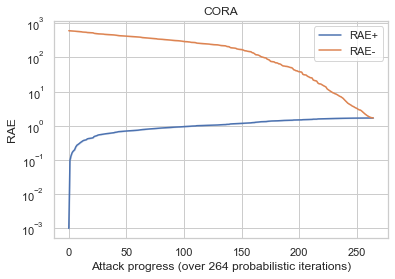

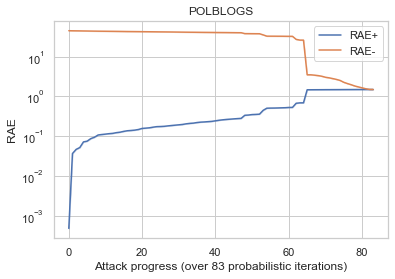

In [22]:
# Plot results
for dataset_name in dataset_names:
    current_results = results[dataset_name]
    for j, (graph1_prop, common_prop) in enumerate(product(graph1_props, common_props)):
        #  results = pd.read_csv(f"logs_hybrid/{dataset_name}_preferential_attachment_A.csv", header=None)
        #  results.columns = ['run', 'attack_type','graph1_prop', 'common_prop', 'iter_num', 'absent', 'present', 'unknown', 'TP', 'FP', 'TN', 'FN', 'time']

        
        current_results = current_results[(current_results['graph1_prop'] == graph1_prop) & (current_results['common_prop'] == common_prop) & (current_results['attack_type'] == 'probabilistic')].copy()
        number_probabilistics = current_results["iter_num"].max()

        current_results.loc[:, "progress"] = (current_results.loc[:, "iter_num"] / current_results.loc[:,"iter_num"].max()).astype(float)

        # print(current_results)

        rae_plus = ((current_results["FP"] + current_results["FN"]) /  graph_statistics[dataset_name]["edges"]).astype(float)
        rae_minus = (( (current_results["FP"] + current_results["FN"] ) + current_results["unknown"] ) / graph_statistics[dataset_name]["edges"]).astype(float)
        
        current_results["rae_plus"] = rae_plus
        current_results["rae_minus"] = rae_minus


        sns.lineplot(x='iter_num', y='rae_plus', data=current_results, label=f'RAE+')
        sns.lineplot(x=current_results["iter_num"], y=current_results['rae_minus'], label=f'RAE-')
        plt.xlabel(f'Attack progress (over {number_probabilistics} probabilistic iterations)')
        plt.ylabel('RAE')
        plt.yscale("log") 
        plt.title(f'{dataset_name.upper()}')
        plt.legend()
        plt.show()


## Proportion of identified edges

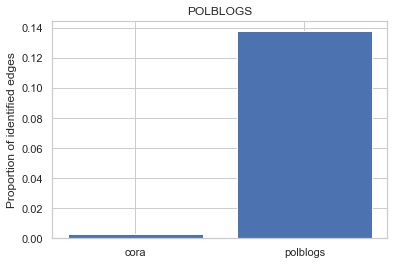

In [28]:
pp = []
for dataset_name in dataset_names:
    current_results = results[dataset_name]
    for j, (graph1_prop, common_prop) in enumerate(product(graph1_props, common_props)):
        current_results = current_results[(current_results['graph1_prop'] == graph1_prop) & (current_results['common_prop'] == common_prop) & (current_results['attack_type'] == 'probabilistic')].copy()

        number_identified_edges = current_results["TP"].max() / graph_statistics[dataset_name]["edges"]
        pp.append(number_identified_edges)

plt.bar(dataset_names, pp)
plt.ylabel('Proportion of identified edges')

plt.title(f'{dataset_name.upper()}')
plt.show()

## Accuracy (number of slots correctly filled in the adjacency matrix)

[0.9980109319362228, 0.9666984347835411]


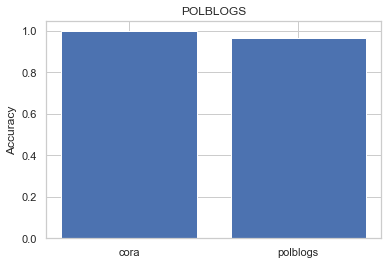

In [30]:
pp = []
for dataset_name in dataset_names:
    current_results = results[dataset_name]
    for j, (graph1_prop, common_prop) in enumerate(product(graph1_props, common_props)):
        current_results = current_results[(current_results['graph1_prop'] == graph1_prop) & (current_results['common_prop'] == common_prop) & (current_results['attack_type'] == 'probabilistic')].copy()

        accuracy = (current_results["TP"].max() + current_results["TN"].max()) / ( graph_statistics[dataset_name]["nodes"] * (graph_statistics[dataset_name]["nodes"] - 1) / 2 )
        pp.append(accuracy)
plt.bar(dataset_names, pp)
plt.ylabel('Accuracy')
plt.title(f'{dataset_name.upper()}')
print(pp)